# Building a language model for Moroccan Darija using fastai

This is a small effort to build a darija language model, i use Moroccan Darija Wikipedia to train an [AWD_LSTM](https://arxiv.org/abs/1708.02182) model using fastai, it is a small dataset which means that this language model won't be perfect for language generation but it might be useful to finetune it on a task like text classification following the [ULMFiT](https://arxiv.org/abs/1801.06146) approach, where you train a language model on Wikipedia text like we do in this notebook to gain some knowledge about the language of your choice, then finetune it on domain-specific data using the same objective of your pretrained language model, in order to bridge the gap between the language used in wikipedia text and the language used in your dataset (e.g., formal language -> informal language), and finally, finetune the language model on the task of your choice.

This model can be improved by:


*   Throwing more data at it of course
*   Some text preprocessing
*   Tuning the hyperparameters
*   I thought also about pretraining on arabic which might be a good idea given the similarities between arabic and darija


---




Let's start by upgrading fastai and installing SentencePiece to use for subword tokenization:

In [ ]:
!pip install fastai -q --upgrade 
!pip install -q sentencepiece!=0.1.90,!=0.1.91 

In [ ]:
import sys
from gensim.corpora import WikiCorpus
from fastai.text.all import *
import torch as torch
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
path = Path('/content/drive/MyDrive/ml/projects/darija/')
dls_path = path/'dls'
model_path = path/'models'
spm_path = model_path/'spm'

dls_path.mkdir(exist_ok=True, parents=True)
model_path.mkdir(exist_ok=True, parents=True)
spm_path.mkdir(exist_ok=True, parents=True)

This is how we can download The Moroccan Darija Wikipedia data, it's available in this [link](https://dumps.wikimedia.org/arywiki/20210520/).

In [ ]:
!wget https://dumps.wikimedia.org/arywiki/latest/arywiki-latest-pages-articles.xml.bz2 -O '/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2'

--2021-08-29 19:53:23--  https://dumps.wikimedia.org/arywiki/latest/arywiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4178623 (4.0M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2’

/content/drive/MyDr 100%[===================>]   3.98M  5.23MB/s    in 0.8s    

2021-08-29 19:53:24 (5.23 MB/s) - ‘/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2’ saved [4178623/4178623]



We make use of [WikiCorpus](https://radimrehurek.com/gensim/corpora/wikicorpus.html) from gensim to convert the XML file we downloaded to a text corpus. 



In [ ]:
def make_corpus(in_f, out_f):

  """Convert Wikipedia xml dump file to text corpus"""

  output = open(out_f, 'w')
  wiki = WikiCorpus(in_f)

  for i, text in enumerate(wiki.get_texts()):
    output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')

    if (i % 1000 == 0):
      print('Processed ' + str(i) + ' articles')
    
  output.close()
  print('Processing complete!')


make_corpus(f'{path}/arywiki-latest-pages-articles.xml.bz2', f'{path}/wiki_darija.txt')

Processed 0 articles
Processed 1000 articles
Processed 2000 articles
Processed 3000 articles
Processing complete!


In [ ]:
path.ls()

(#10) [Path('/content/drive/MyDrive/ml/projects/darija/arwiki.xml.bz2'),Path('/content/drive/MyDrive/ml/projects/darija/dls'),Path('/content/drive/MyDrive/ml/projects/darija/models'),Path('/content/drive/MyDrive/ml/projects/darija/arwiki-latest-pages-articles.xml.bz2'),Path('/content/drive/MyDrive/ml/projects/darija/wiki_arabic.txt'),Path('/content/drive/MyDrive/ml/projects/darija/Untitled0.ipynb'),Path('/content/drive/MyDrive/ml/projects/darija/Copie de darija_lm.ipynb'),Path('/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2'),Path('/content/drive/MyDrive/ml/projects/darija/wiki_darija.txt'),Path('/content/drive/MyDrive/ml/projects/darija/darija_lm.ipynb')]

Now we load our text data as a pandas dataframe, and we take a look at it using the most advanced EDA technique 😄, we can see that there are words from other languages that will most likely disappear  due to their low frequency, and we can tell fastai the minimum word frequency (by default it’s 3) we can tolerate using fastai DataBlocks that we discuss below.

In [ ]:
df = pd.read_csv(path/'wiki_darija.txt', header=None, names=['text'])
df.head()

,text
0,آبطح جماعة ترابية قروية كاينة إقليم عمالة طان طان جهة ݣلميم واد نون ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون
1,آسفي بالأمازيغية ⴰⵙⴼⵉ هي مدينة مغربية جات إقليم آسفي جهة مراكش آسفي آسفي معروفة بالفخار والحوت وخصوصا السردين ومكنيين عليها حاضرة المحيط الحطة ديال آسفي جات كاطل على المحيط الأطلسي بين الجديدة والصويرة في آسفي كاين بزاف دالبني لي قديم وتاريخي وهي من بين المدون القديمة في المغرب ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خد...
2,آلبرخت دورر بالألمانية albrecht dürer ماي أبريل رسام صانع طباعة وم كاينتامي لعصر النهضة الألمانية تزاد في نورمبرݣ دورر أسس للسمعة والتأثير ديالو عبر أوروبا فالوقت اللي مازالا فالعشرينات من عمرو نتيجة لجودة نقوشاتو الخشبية كان فاتصال مع أكبر الفنانين الإيطاليين فالعصر ديالو بما فيهم رفائيل جيوڤاني بيليني وليوناردو دا ڤينتشي وابتداء من كان كي اخد الدعم من عند الإمبراطور ماكسيميليان الأول تم تشييع دورر فالكنيستين اللوثرية والأسقفية بجوج كتشمل مجموعة أعمال دورر الواسعة النقوش أسلوبو المفضل في طبعاتو الأخيرة الأعمال الفنية فالكنائس altarpieces پورتريهات پورتريهات ذاتية لوحات مائية وك النقوش الخ...
3,آمتدي جماعة ترابية قروية كاينة إقليم عمالة ݣلميم جهة ݣلميم واد نون ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون
4,آنفݣ جماعة ترابية قروية كاينة إقليم عمالة سيدي إيفني جهة ݣلميم واد نون ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون


Subword tokenization refers to constructing our vocabulary using the most frequently occurring groups of letters, for instance, the word “transformer” could be split into “trans” and “former”. I find it better to use subword tokenization with a relatively smaller vocabulary size in the case of a small dataset, to avoid the p>>n problem (where the number of features exceeds the number of training examples), and also because if we decide to use words as our tokens, we are going to have a lot of words that appear only a few times throughout the corpus, and the model won’t be given a decent chance to learn about them.

I use a maximum vocabilary size of 1000 specified by the `max_vocab_sz` parameter, but you can use less or more, its another hyperparamter you can tune based on the metric you care about.

The data block API is provided by fastai to customize the creation of our dataloaders, `blocks` parameter is used to specify the type of our independent and dependent variables, when `TextBlock` is passed, fastai takes care of preprocessing for us, we just need to pass it our subword tokenizer since it uses word tokenization by default, we also tell fastai that we are building this for language modeling with `is_lm` and that our text is in a dataframe.

And finally we create our dataloaders, it's a dataloader with s because it includes the training and validation dataloaders, the validation set is 10% of our data as we specify in our `RandomSplitter`.






In [ ]:
bs=128

tok = SubwordTokenizer(cache_dir=spm_path, max_vocab_sz=1000)

dls_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True, tok=tok),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_x=ColReader('text')
                   ).dataloaders(df, bs=bs)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


We save our dataloader since we can't afford to create it each time because of our huge dataset 😅.

In [ ]:
torch.save(dls_lm, dls_path/'dls_lm.pkl')

This is how our preprocessed text looks like, spaces in the original text are replaced by ▁, xxbos is a special token added by fastai to signify the beginning of a sentence, fastai also adds other special tokens to make learning easier for the model, we can see them when we check our vocab below.

In [ ]:
dls_lm.show_batch(max_n=6)

,text,text_
0,▁xxbos ▁بني ▁من ص ور ▁جماع ة ▁ترابية ▁قرو ية ▁كاين ة ▁إقليم ▁عمال ة ▁إقليم ▁ ش ف ش ا ون ▁جه ة ▁طنج ة ▁تطوان ▁الحسيمة ▁ساكنين ▁فيها ▁واحد ▁عل ى ▁حسب ▁ل إحصاء ▁لعام ▁تعليم ▁نسبة ▁لأمي ة ▁اس ▁ما ▁كايعرفو ش ▁يقرا و ▁ولا ▁يكتب و ▁نسبة ▁كان ▁ قاريين ▁فوق ▁ انوي ▁تانوي ▁جامع ة ▁اقتصاد ▁نسبة ▁اس ▁شيط ين ▁ يقدرو ▁ يخدمو ▁نسبة ▁لبطال ة,▁بني ▁من ص ور ▁جماع ة ▁ترابية ▁قرو ية ▁كاين ة ▁إقليم ▁عمال ة ▁إقليم ▁ ش ف ش ا ون ▁جه ة ▁طنج ة ▁تطوان ▁الحسيمة ▁ساكنين ▁فيها ▁واحد ▁عل ى ▁حسب ▁ل إحصاء ▁لعام ▁تعليم ▁نسبة ▁لأمي ة ▁اس ▁ما ▁كايعرفو ش ▁يقرا و ▁ولا ▁يكتب و ▁نسبة ▁كان ▁ قاريين ▁فوق ▁ انوي ▁تانوي ▁جامع ة ▁اقتصاد ▁نسبة ▁اس ▁شيط ين ▁ يقدرو ▁ يخدمو ▁نسبة ▁لبطال ة ▁اس
1,▁ديال ك م ▁لل ن س ا ▁ ون ▁ديالو ▁ ون ▁س ن ▁ديال هم ▁ ون ▁س نت ▁ديال هم ▁لل ن س ا ▁الم ل ك ية ▁لل ن س ا ▁ل لو حد ة ▁ت ن ▁ ين و ▁ديال تي ▁ت ن ▁ديال ت نا ▁ت ن ▁ديال ت ك ▁ ذ كر ▁ت ن ▁ت ن ▁ديال ت ك م ▁ت ن ▁ديال ت كي ▁م,ك م ▁لل ن س ا ▁ ون ▁ديالو ▁ ون ▁س ن ▁ديال هم ▁ ون ▁س نت ▁ديال هم ▁لل ن س ا ▁الم ل ك ية ▁لل ن س ا ▁ل لو حد ة ▁ت ن ▁ ين و ▁ديال تي ▁ت ن ▁ديال ت نا ▁ت ن ▁ديال ت ك ▁ ذ كر ▁ت ن ▁ت ن ▁ديال ت ك م ▁ت ن ▁ديال ت كي ▁م ؤ
2,▁من ▁ وف ▁ع س ف ▁خ ل ▁ؤلا ▁لخ ش ب ▁م غ لف ة ▁م زي ان ▁ طر ف ▁ل د ▁ديال ▁ب ݣر ة ▁ؤلا ▁ت ور ▁لك ور ة ▁باش ▁كي لعب و ▁جا ل ▁كت كون ▁ع اد ة ▁ت قل ▁من ▁كي لعب و ▁ بي ها ▁سا ▁و ع ب ة ▁مر ات ▁كت كون ▁خ ط ير ة ▁ ك يقدرو ▁يو ق,▁ وف ▁ع س ف ▁خ ل ▁ؤلا ▁لخ ش ب ▁م غ لف ة ▁م زي ان ▁ طر ف ▁ل د ▁ديال ▁ب ݣر ة ▁ؤلا ▁ت ور ▁لك ور ة ▁باش ▁كي لعب و ▁جا ل ▁كت كون ▁ع اد ة ▁ت قل ▁من ▁كي لعب و ▁ بي ها ▁سا ▁و ع ب ة ▁مر ات ▁كت كون ▁خ ط ير ة ▁ ك يقدرو ▁يو ق ع
3,ات ▁وال طا كس يات ▁لي ▁عند هم ▁الح ق ▁ي دخل و ▁لي ها ▁ ا ص لا ح ▁ال قص ب ة ▁م ش رو ع ▁ ا ص لا ح ▁ق صب ة ▁أ ݣ اد ير ▁أو ف لا ▁هو ▁م ش رو ع ▁إ ن طل ق ▁عام ▁وت اي هد ف ▁باش ▁ي ص ل ح ▁ اوي أ ه ل ▁الس و ار ▁د ال,▁وال طا كس يات ▁لي ▁عند هم ▁الح ق ▁ي دخل و ▁لي ها ▁ ا ص لا ح ▁ال قص ب ة ▁م ش رو ع ▁ ا ص لا ح ▁ق صب ة ▁أ ݣ اد ير ▁أو ف لا ▁هو ▁م ش رو ع ▁إ ن طل ق ▁عام ▁وت اي هد ف ▁باش ▁ي ص ل ح ▁ اوي أ ه ل ▁الس و ار ▁د ال قص
4,▁لعاط لين ▁اللي ▁سبق ▁ل يهوم ▁خدمو ▁عيون ▁لكلام ▁تصنيف ▁جه ة ▁مراكش ▁آسفي ▁xxbos ▁لح اج ▁لح س ين ▁الت ول الي ▁تولد ▁ت ول ال ▁مات ▁نهار ▁د ج ن بر ▁ف م ك ناس ▁كان ▁ف ن ان ▁م غرب ي ▁ديال ▁لم ل ح ون ▁الح س ين ▁الت ول الي ▁تولد ▁ف ت ول ال ▁ح دا ▁مكناس ▁و كان و ▁تي هضر و ▁بال ش ل,لين ▁اللي ▁سبق ▁ل يهوم ▁خدمو ▁عيون ▁لكلام ▁تصنيف ▁جه ة ▁مراكش ▁آسفي ▁xxbos ▁لح اج ▁لح س ين ▁الت ول الي ▁تولد ▁ت ول ال ▁مات ▁نهار ▁د ج ن بر ▁ف م ك ناس ▁كان ▁ف ن ان ▁م غرب ي ▁ديال ▁لم ل ح ون ▁الح س ين ▁الت ول الي ▁تولد ▁ف ت ول ال ▁ح دا ▁مكناس ▁و كان و ▁تي هضر و ▁بال ش ل ح
5,▁كايعرفو ش ▁يقرا و ▁ولا ▁يكتب و ▁نسبة ▁كان ▁ قاريين ▁فوق ▁ انوي ▁تانوي ▁جامع ة ▁اقتصاد ▁نسبة ▁اس ▁شيط ين ▁ يقدرو ▁ يخدمو ▁نسبة ▁لبطال ة ▁اس ▁ما ▁خدامين ش ▁تايق لبو ▁عل ى ▁خدم ة ▁نسبة ▁اس ▁اللي ▁خدامين ▁ول ة ▁نسبة ▁اس ▁اللي ▁خدامين ▁في ▁لقطاع ▁لخاص ▁عيون ▁لكلام ▁تصنيف ▁جه ة ▁درع ة ▁تافيلالت ▁xxbos ▁إي م يل ما يس ▁جماع ة ▁ترابية ▁قرو ية ▁كاين,ش ▁يقرا و ▁ولا ▁يكتب و ▁نسبة ▁كان ▁ قاريين ▁فوق ▁ انوي ▁تانوي ▁جامع ة ▁اقتصاد ▁نسبة ▁اس ▁شيط ين ▁ يقدرو ▁ يخدمو ▁نسبة ▁لبطال ة ▁اس ▁ما ▁خدامين ش ▁تايق لبو ▁عل ى ▁خدم ة ▁نسبة ▁اس ▁اللي ▁خدامين ▁ول ة ▁نسبة ▁اس ▁اللي ▁خدامين ▁في ▁لقطاع ▁لخاص ▁عيون ▁لكلام ▁تصنيف ▁جه ة ▁درع ة ▁تافيلالت ▁xxbos ▁إي م يل ما يس ▁جماع ة ▁ترابية ▁قرو ية ▁كاين ة


Special tokens in fastai start with letters xx, they are useful to help our model handle the shift from original text to our preprocessed text. For example, `xxunk` is used to replace the tokens that don't exist in our vocab, 
as it can be useful to help our model learn to deal with missing tokens.

In [ ]:
print(dls_lm.vocab[:20])

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxrep', 'xxwrep', 'xxup', 'xxmaj', '▁', 'ة', 'و', 'ا', '▁ل', '▁ال', 'ش', 'م', 'ات', 'ل', 'ر']


Now it's time to create our language model learner, we pass it our dataloaders, and use the version of AWD_LSTM provided by fastai.

Perplexity is usually used to evaluate language models, a model with a low perplexity is one that assigns a high probabilty to the correct output, in our case, the model learns by trying to predict the next token in a sequence, so the lower the perplexity the better is our model at predicting the next token correctly. Perplexity is a good metric to look at when training your language model and tuning the different hyperparamters, but i think the best way to measure the quality of a language model is to actually apply it on a task (text classifcation, question ansewring, ...) and look at your accuracy (or any other metric) going up or down.

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, 
    metrics=[accuracy, Perplexity()], pretrained=False)

AWD_LSTM is just LSTM layers with lots of regularization, and we can see that in the hyperparamters below in fastai's implementation, all the parameters that end with 'p' are the ammount of dropout applied to some part of the network. Other regularization techniques are also used, like [*activation regularization*](https://paperswithcode.com/method/activation-regularization) which is similar to weight decay but applied to the activations instead of the weights. 
Another interesting technique is [*weight tying*](https://paperswithcode.com/method/weight-tying), that is based on the intuition that out embedding layer is a mapping from *darija* to a vector representation, and our output layer is a mapping from a vector representation back to *darija*, so why not use the same weight matrix for both of them, this turn out to be a useful method to reduce the number of parameters of a language model especially when we have a huge vocabulary size.

In [ ]:
awd_lstm_lm_config

{'bidir': False,
 'emb_sz': 400,
 'embed_p': 0.02,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'n_hid': 1152,
 'n_layers': 3,
 'out_bias': True,
 'output_p': 0.1,
 'pad_token': 1,
 'tie_weights': True,
 'weight_p': 0.2}

Time to train our model using the one cycle policy, that was introduced in [this paper](https://arxiv.org/abs/1803.09820). It is a method that suggests varying the learning rate linearly in two steps, one where we go from a small learning rate to a maximum learning rate that we specify (in this case `max_lr=1e-2`), then decreasing it to a lower value than the one we started with.


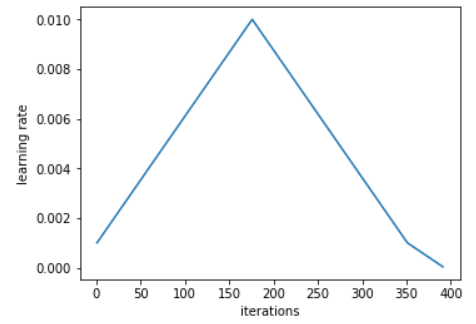

Starting from a low learning rate is used as a warm-up step and has the effect of allowing the model to get used to the data before jumping to a high learning rate, when we reach the maximum learning rate, it acts as a regularization that helps the model escape saddle points and avoid steep areas of the loss and prefer a flatter minimum, that we can navigate while decreasing our learning rate in the second step.

In [ ]:
learn.fit_one_cycle(n_epoch=50, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.515688,5.475324,0.047372,238.727844,01:51
1,5.483952,5.467685,0.048320,236.911163,01:52
2,4.817659,4.317418,0.184282,74.994751,01:52
3,4.145897,4.027465,0.210001,56.118462,01:51
4,3.805228,3.598531,0.272597,36.544495,01:52
5,3.457134,3.275732,0.328941,26.462589,01:52
6,3.179850,3.041847,0.368637,20.943880,01:51
7,2.990458,2.920819,0.386745,18.556480,01:51
8,2.897987,2.895197,0.395819,18.087059,01:51
9,2.838742,2.817706,0.407951,16.738407,01:51


In [ ]:
learn.save(model_path/'darija_lm')

Path('/content/drive/MyDrive/ml/projects/darija/models/darija_lm.pth')

In [ ]:
def decoder(sentence):
  s = ''.join(sentence)
  return s.split('▁')

We use the predict method to generate two sentences with 100 subwords each, it will take a piece of text as input and start doing the usual work of predicting the next token. We don't just take the word with the highest probability but we randomly sample from a probability distribution (the output of the softmax), this is done because we want our model to be a little creative and not just keep repeating itself; a high temperature will smooth this probability distribution and give tokens with low probability a higher chance of being sampled.

In [ ]:
text = 'رسام صانع طباعة'
n_toks = 100
n_sentences = 2
preds = [learn.predict(text, n_toks, temperature=0.75, decoder=decoder)
        for _ in range(n_sentences)]

This is the output of our model, we have ourselves a drunk GPT-3 😄, but we can see that it's able to generate words correctly even though we are using subwords, this is more apparent when we look at the output of our model without the decoder below. 

In [ ]:
preds

[' xxbos رسام صانع طباعة للفنون بلفورمة لبرتغالية electura cafécie مكتوب من الجزء الجديد هي من كتاب تصفيات فالطريق اللي ربح لبوطولات ديال صاموا الدانمارك مستعمرة فياسوات طويلة وقعات يناير كاتبة و',
 ' xxbos رسام صانع طباعة مدريد تماشق حديدية لعربية ديال أتلتيكو مدريد وزارة الخارجية تزادت أكتوبر وسلامة وسهول پريمو سك ان ألمانيا ليمن ديال ألمانيا لي كاتكون ديكارط بحرية مع البطولة ديالو على بيتكوين لباشار مورا ما تعطاو']

In [ ]:
text = 'رسام صانع طباعة'
n_toks = 100
n_sentences = 2
preds = [learn.predict(text, n_toks, temperature=0.75)
        for _ in range(n_sentences)]

The output without a decoder, tokens are separated by spaces, while the actual space is replaced by ▁, you might notice that the output is different  because we are randomly sampling.

In [ ]:
preds

['▁xxbos ▁ ر س ام ▁ ص ان ع ▁ ط ب اع ة ▁ت ف اح ة ▁ ش ف يق ▁م خ ت ال ف ة ▁عل ى ▁ ش ح ال ▁من ▁واحد ▁الس خ ان ة ▁كبير ة ▁كت ر ▁من ▁ ها ك ▁ اك ▁م غ ار بي ة ▁كات ع ط ى ▁لل ح ب س ▁ يا ▁أ ك ث ر ▁من ها ▁ ش ك ل ▁م م ل ك ة ▁مو ري طان ية ▁هاد شي ▁لي ▁خ لا ▁ ناس ▁ ر د ات و ▁لم ت غ ير ات ▁د ين ية ▁عل ى ▁ل و غ ات ▁ نت ج ات',
 '▁xxbos ▁ ر س ام ▁ ص ان ع ▁ ط ب اع ة ▁م ص در ▁مح ل ول ▁ت خ تار ع ات ▁عل ى ▁الم ج ال ▁ال آ خر ▁عل ى ▁ح ق و ق ▁بن اد م ▁ ش وف ▁حتا ▁ ست ا قل ات ▁ع ا ون ات ها ▁لق ر آ ن ▁من ▁بعد ▁ما خد ا ها ▁لع د د ▁ديال ▁ال ناس ▁لي ▁كان ▁عند هوم ▁م جل ة ▁لم رك زي ة ▁ در ية ▁ع اد ▁ طل ع ات ▁باش ▁ت ع طا ▁لل ق با يل ية ▁لم ؤ س س ات ▁ديال ▁ال ناس ▁ول كن ▁كات كون ▁فيها']